In [ ]:
#simplejson wheel matplotlib seaborn bs4

In [19]:
!{sys.executable} -m pip install networkx 

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Uninstalling decorator-5.0.9:
      Successfully uninstalled decorator-5.0.9


In [15]:
import argparse
import re, random, urllib, simplejson, copy, itertools
import urllib.parse, urllib.request, urllib.error
from datetime import datetime
# urllib.parse, urllib.request and urllib.error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set_style('whitegrid')

import requests, json, time, os

In [20]:
from pathlib import Path

from operator import itemgetter
from collections import Counter
from bs4 import BeautifulSoup

import wikifunctions as wf

from multiprocessing import Pool, Manager, Process, cpu_count
from functools import partial

In [21]:
langs = ["de","en","es","fr","ja"]

# list of rules
rules_df_de = pd.read_csv(Path(os.getcwd()) / "rules" / "dewiki.tsv",sep="\t",header=None)
rules_df_en = pd.read_csv(Path(os.getcwd()) / "rules" / "enwiki.tsv",sep="\t",header=None)
rules_df_es = pd.read_csv(Path(os.getcwd()) / "rules" / "eswiki.tsv",sep="\t",header=None)
rules_df_fr = pd.read_csv(Path(os.getcwd()) / "rules" / "frwiki.tsv",sep="\t",header=None)
rules_df_ja = pd.read_csv(Path(os.getcwd()) / "rules" / "jawiki.tsv",sep="\t",header=None)
rules_dfs = [rules_df_de,rules_df_en,rules_df_es,rules_df_fr,rules_df_ja]

# page revision histories
rev_path = Path(os.getcwd()) / "output_rulepagerevs" / "2021-01-11" #/ "2020-07-31"

rev_df_de = pd.read_csv( rev_path / "de_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_en = pd.read_csv( rev_path / "en_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_es = pd.read_csv( rev_path / "es_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_fr = pd.read_csv( rev_path / "fr_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])
rev_df_ja = pd.read_csv( rev_path / "ja_revisions.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'])


# talk page revision histories
talkrev_df_de = pd.read_csv( rev_path / "de_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_en = pd.read_csv( rev_path / "en_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_es = pd.read_csv( rev_path / "es_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_fr = pd.read_csv( rev_path / "fr_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)
talkrev_df_ja = pd.read_csv( rev_path / "ja_revisions_talk.tsv",sep='\t',header=0,encoding='utf8',parse_dates=['date','timestamp'],low_memory=False)

C:\Users\sohyeon\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sohyeon\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (0,3,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
# get rid of duplicate revisions for each language edition
rev_df_de.drop_duplicates(subset=['revid'],inplace=True)
rev_df_en.drop_duplicates(subset=['revid'],inplace=True)
rev_df_es.drop_duplicates(subset=['revid'],inplace=True)
rev_df_fr.drop_duplicates(subset=['revid'],inplace=True)
rev_df_ja.drop_duplicates(subset=['revid'],inplace=True)

talkrev_df_de.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_en.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_es.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_fr.drop_duplicates(subset=['revid'],inplace=True)
talkrev_df_ja.drop_duplicates(subset=['revid'],inplace=True)

In [23]:
rev_df_de.dropna(subset=['revid','date','diff','lag'],inplace=True)
rev_df_en.dropna(subset=['revid','date','diff','lag'],inplace=True)
rev_df_es.dropna(subset=['revid','date','diff','lag'],inplace=True)
rev_df_fr.dropna(subset=['revid','date','diff','lag'],inplace=True)
rev_df_ja.dropna(subset=['revid','date','diff','lag'],inplace=True)

talkrev_df_de.dropna(subset=['revid','date','diff','lag'],inplace=True)
talkrev_df_en.dropna(subset=['revid','date','diff','lag'],inplace=True)
talkrev_df_es.dropna(subset=['revid','date','diff','lag'],inplace=True)
talkrev_df_fr.dropna(subset=['revid','date','diff','lag'],inplace=True)
talkrev_df_ja.dropna(subset=['revid','date','diff','lag'],inplace=True)

In [24]:
# make a column for the year of the revision
rev_df_de['year'] = rev_df_de['timestamp'].dt.strftime('%Y')
rev_df_de['year'] = rev_df_de['year'].astype(np.int64)
talkrev_df_de['year'] = talkrev_df_de['timestamp'].dt.strftime('%Y')
talkrev_df_de['year'] = talkrev_df_de['year'].astype(np.int64)

rev_df_en['year'] = rev_df_en['date'].dt.strftime('%Y')
rev_df_en['year'] = rev_df_en['year'].astype(np.int64)
talkrev_df_en['year'] = talkrev_df_en['timestamp'].dt.strftime('%Y')
talkrev_df_en['year'] = talkrev_df_en['year'].astype(np.int64)

rev_df_es['year'] = rev_df_es['timestamp'].dt.strftime('%Y')
rev_df_es['year'] = rev_df_es['year'].astype(np.int64)
talkrev_df_es['year'] = talkrev_df_es['timestamp'].dt.strftime('%Y')
talkrev_df_es['year'] = talkrev_df_es['year'].astype(np.int64)

rev_df_fr['year'] = rev_df_fr['timestamp'].dt.strftime('%Y')
rev_df_fr['year'] = rev_df_fr['year'].astype(np.int64)
talkrev_df_fr['year'] = talkrev_df_fr['timestamp'].dt.strftime('%Y')
talkrev_df_fr['year'] = talkrev_df_fr['year'].astype(np.int64)

rev_df_ja['year'] = rev_df_ja['timestamp'].dt.strftime('%Y')
rev_df_ja['year'] = rev_df_ja['year'].astype(np.int64)
talkrev_df_ja['year'] = talkrev_df_ja['timestamp'].dt.strftime('%Y')
talkrev_df_ja['year'] = talkrev_df_ja['year'].astype(np.int64)

print('de')
print(rev_df_de.shape)
print(talkrev_df_de.shape) # one less because commenthidden column not there

print('en')
print(rev_df_en.shape)
print(talkrev_df_en.shape)

print('es')
print(rev_df_es.shape) # no suppressed column
print(talkrev_df_es.shape) # no suppressed column

print('fr')
print(rev_df_fr.shape)
print(talkrev_df_fr.shape) # no userhidden column

print('ja')
print(rev_df_ja.shape) # no suppressed column
print(talkrev_df_ja.shape) # no suppressed column

de
(40620, 19)
(138265, 18)
en
(266540, 19)
(1092305, 19)
es
(27625, 18)
(10244, 18)
fr
(31466, 19)
(37121, 18)
ja
(16694, 19)
(37601, 18)


In [25]:
rev_df_de['year_since_first'] = rev_df_de.year.astype(np.int64) - rev_df_de.year.astype(np.int64).min()
rev_df_en['year_since_first'] = rev_df_en.year.astype(np.int64) - rev_df_en.year.astype(np.int64).min()
rev_df_es['year_since_first'] = rev_df_es.year.astype(np.int64) - rev_df_es.year.astype(np.int64).min()
rev_df_fr['year_since_first'] = rev_df_fr.year.astype(np.int64) - rev_df_fr.year.astype(np.int64).min()
rev_df_ja['year_since_first'] = rev_df_ja.year.astype(np.int64) - rev_df_ja.year.astype(np.int64).min()

talkrev_df_de['year_since_first'] = talkrev_df_de.year.astype(np.int64) - rev_df_de.year.astype(np.int64).min()
talkrev_df_en['year_since_first'] = talkrev_df_en.year.astype(np.int64) - rev_df_en.year.astype(np.int64).min()
talkrev_df_es['year_since_first'] = talkrev_df_es.year.astype(np.int64) - rev_df_es.year.astype(np.int64).min()
talkrev_df_fr['year_since_first'] = talkrev_df_fr.year.astype(np.int64) - rev_df_fr.year.astype(np.int64).min()
talkrev_df_ja['year_since_first'] = talkrev_df_ja.year.astype(np.int64) - rev_df_ja.year.astype(np.int64).min()

In [26]:
rev_df_de = rev_df_de[rev_df_de.year <= 2020]
rev_df_en = rev_df_en[rev_df_en.year <= 2020]
rev_df_es = rev_df_es[rev_df_es.year <= 2020]
rev_df_fr = rev_df_fr[rev_df_fr.year <= 2020]
rev_df_ja = rev_df_ja[rev_df_ja.year <= 2020]

talkrev_df_de = talkrev_df_de[talkrev_df_de.year <= 2020]
talkrev_df_en = talkrev_df_en[talkrev_df_en.year <= 2020]
talkrev_df_es = talkrev_df_es[talkrev_df_es.year <= 2020]
talkrev_df_fr = talkrev_df_fr[talkrev_df_fr.year <= 2020]
talkrev_df_ja = talkrev_df_ja[talkrev_df_ja.year <= 2020]

In [27]:
# parent pages for matching rule and talk
rev_df_en['parent_page_title'] = rev_df_en.copy()['page']
rev_df_de['parent_page_title'] = rev_df_de.copy()['page']
rev_df_es['parent_page_title'] = rev_df_es.copy()['page']
rev_df_fr['parent_page_title'] = rev_df_fr.copy()['page']
rev_df_ja['parent_page_title'] = rev_df_ja.copy()['page']

talkrev_df_en['parent_page_title'] = talkrev_df_en['page'].apply(lambda x:x[:9]+x[14:] if x[:9]=='Wikipedia' else x[:8]+x[13:])
talkrev_df_de['parent_page_title'] = talkrev_df_de['page'].apply(lambda x:x[:9]+x[20:] if x[:9]=='Wikipedia' else x[:6]+x[17:])
talkrev_df_es['parent_page_title'] = talkrev_df_es['page'].apply(lambda x:x[:9]+x[19:])
talkrev_df_fr['parent_page_title'] = talkrev_df_fr['page'].apply(lambda x:x[11:])
talkrev_df_ja['parent_page_title'] = talkrev_df_ja['page'].apply(lambda x:x[:9]+x[13:] if x[:9]=='Wikipedia' else x[:6]+x[10:])

def usuaria(row):
    if "Usuaria discusión:" in row['page']:
        if "Usuaria discusión:" == row['page'][:18]:
            print(row['page'], '\t', row['parent_page_title'])
            fixed = "Usuaria:{}".format(row['page'][18:])
            print(fixed)
            return fixed
    else:
        return row['parent_page_title']

talkrev_df_es['parent_page_title'] = talkrev_df_es.apply(usuaria,axis=1)

Usuaria discusión:Userbox mujer 	 Usuaria dserbox mujer
Usuaria:Userbox mujer
Usuaria discusión:Userbox mujer 	 Usuaria dserbox mujer
Usuaria:Userbox mujer
Usuaria discusión:Userbox mujer 	 Usuaria dserbox mujer
Usuaria:Userbox mujer


In [28]:
## 27 may -- updates to rule list...

rev_df_ja = rev_df_ja.loc[rev_df_ja.parent_page_title != "Wikipedia:著作権/20080630迄"] # this page doesn't exist anymore, so just in case, remove...
talkrev_df_ja = talkrev_df_ja.loc[talkrev_df_ja.parent_page_title != "Wikipedia:著作権/20080630迄"] # this page doesn't exist anymore, so just in case, remove...

# remove this failed proposal
rev_df_en = rev_df_en.loc[rev_df_en.page != "Wikipedia:Manual_of_Style/Computing"]
rev_df_en = rev_df_en.loc[rev_df_en.parent_page_title != 'Wikipedia:Manual of Style/Computing (failed proposal)']
talkrev_df_en = talkrev_df_en.loc[talkrev_df_en.parent_page_title != "Wikipedia:Manual_of_Style/Computing"]
talkrev_df_en = talkrev_df_en.loc[talkrev_df_en.parent_page_title != "Wikipedia:Manual_of_Style/Computing (failed proposal)"]

In [29]:
#_df = policy_rev_df.groupby(['page_title','date']).agg({'size':np.median}).unstack(0)['size']
#policy_d = {col:_df[col].first_valid_index() for col in _df.columns}
min_rulerev_date = rev_df_de.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_de = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_en.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_en = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_es.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_es = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_fr.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_fr = min_rulerev_date.to_dict()

min_rulerev_date = rev_df_ja.groupby(['page']).agg({'date':np.min})['date']
min_rulerev_date_dict_ja = min_rulerev_date.to_dict()

rev_df_de['creation_year'] = rev_df_de['page'].map({k:v.year for k,v in min_rulerev_date_dict_de.items()})
rev_df_en['creation_year'] = rev_df_en['page'].map({k:v.year for k,v in min_rulerev_date_dict_en.items()})
rev_df_es['creation_year'] = rev_df_es['page'].map({k:v.year for k,v in min_rulerev_date_dict_es.items()})
rev_df_fr['creation_year'] = rev_df_fr['page'].map({k:v.year for k,v in min_rulerev_date_dict_fr.items()})
rev_df_ja['creation_year'] = rev_df_ja['page'].map({k:v.year for k,v in min_rulerev_date_dict_ja.items()})

# For talk pages, use their parent title
talkrev_df_de['creation_year'] = talkrev_df_de['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_de.items()})
talkrev_df_en['creation_year'] = talkrev_df_en['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_en.items()})
talkrev_df_es['creation_year'] = talkrev_df_es['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_es.items()})
talkrev_df_fr['creation_year'] = talkrev_df_fr['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_fr.items()})
talkrev_df_ja['creation_year'] = talkrev_df_ja['parent_page_title'].map({k:v.year for k,v in min_rulerev_date_dict_ja.items()})

# rev_df_en timestamp needs to be made into a datetime object
rev_df_en['timestamp'] = pd.to_datetime(rev_df_en['timestamp'])

In [30]:
# combine all_revs per language edition (page + talk) again, with the new stuff
allrevs_de = pd.concat([rev_df_de,talkrev_df_de]).sort_values('timestamp')
allrevs_en = pd.concat([rev_df_en,talkrev_df_en]).sort_values('timestamp')
allrevs_es = pd.concat([rev_df_es,talkrev_df_es]).sort_values('timestamp')
allrevs_fr = pd.concat([rev_df_fr,talkrev_df_fr]).sort_values('timestamp')
allrevs_ja = pd.concat([rev_df_ja,talkrev_df_ja]).sort_values('timestamp')

In [31]:
rev_df_list = [rev_df_en,rev_df_fr,rev_df_de,rev_df_ja,rev_df_es]
talkrev_df_list = [talkrev_df_en,talkrev_df_fr,talkrev_df_de,talkrev_df_ja,talkrev_df_es]
allrev_df_list = [allrevs_en,allrevs_fr,allrevs_de,allrevs_ja,allrevs_es]

rev_df_names = ['English','French','German','Japanese','Spanish']

## Descriptives

In [32]:
print('Through 2020...')
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('German', len(set(rev_df_de['page'])), len(set(talkrev_df_de['page'])), len(allrevs_de['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('English', len(set(rev_df_en['page'])), len(set(talkrev_df_en['page'])), len(allrevs_en['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('Spanish', len(set(rev_df_es['page'])), len(set(talkrev_df_es['page'])), len(allrevs_es['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('French', len(set(rev_df_fr['page'])), len(set(talkrev_df_fr['page'])), len(allrevs_fr['user'].unique()) ))
print('In {} Wikipedia, there are {} rule pages and {} corresponding talk pages; {} unique users contributed to these'.format('Japanese', len(set(rev_df_ja['page'])), len(set(talkrev_df_ja['page'])), len(allrevs_ja['user'].unique()) ))
print("{} total pages".format('780'))

print( 'German:\t\t {}\t{}'.format( allrevs_de['timestamp'].min(), allrevs_de['timestamp'].max() ))
print( 'English:\t {}\t{}'.format( allrevs_en['timestamp'].min(), allrevs_en['timestamp'].max() ))
print( 'Spanish:\t {}\t{}'.format( allrevs_es['timestamp'].min(), allrevs_es['timestamp'].max() ))
print( 'French:\t\t {}\t{}'.format( allrevs_fr['timestamp'].min(), allrevs_fr['timestamp'].max() ))
print( 'Japanese:\t {}\t{}'.format( allrevs_ja['timestamp'].min(), allrevs_ja['timestamp'].max() ))

Through 2020...
In German Wikipedia, there are 122 rule pages and 115 corresponding talk pages; 13587 unique users contributed to these
In English Wikipedia, there are 313 rule pages and 309 corresponding talk pages; 80441 unique users contributed to these
In Spanish Wikipedia, there are 105 rule pages and 90 corresponding talk pages; 7112 unique users contributed to these
In French Wikipedia, there are 127 rule pages and 120 corresponding talk pages; 6411 unique users contributed to these
In Japanese Wikipedia, there are 113 rule pages and 112 corresponding talk pages; 5517 unique users contributed to these
780 total pages
German:		 2001-06-19 06:38:40+00:00	2020-12-31 23:31:51+00:00
English:	 2001-03-08 17:58:55+00:00	2020-12-31 23:42:31+00:00
Spanish:	 2002-01-11 19:58:15+00:00	2020-12-31 11:50:10+00:00
French:		 2001-11-26 20:48:06+00:00	2020-12-31 20:47:43+00:00
Japanese:	 2003-02-02 09:10:23+00:00	2020-12-31 00:19:50+00:00


## Figures (RQ1)

Figure 1 - rule flow chart in PPT

In [33]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid")

In [34]:
linestyles = ['-','--','-','--','-','--','-','--']
year_order = range(2001,2021)
_hue_order = ['English','French','German','Japanese','Spanish']

creation_by_year_df = pd.DataFrame(index=range(2001,2021))

creation_by_year_df['German'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_de.values()]))
creation_by_year_df['English'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_en.values()]))
creation_by_year_df['Spanish'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_es.values()]))
creation_by_year_df['French'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_fr.values()]))
creation_by_year_df['Japanese'] = pd.Series(Counter([pd.to_datetime(i).year for i in min_rulerev_date_dict_ja.values()]))

creation_by_year_df_years_since = creation_by_year_df.reset_index()
creation_by_year_df_years_since['Japanese'] = creation_by_year_df_years_since['Japanese'].shift(-2)
creation_by_year_df_years_since['Spanish'] = creation_by_year_df_years_since['Spanish'].shift(-1)
#creation_by_year_df_years_since['years_since'] = range(1,21)
creation_by_year_df_years_since = creation_by_year_df_years_since.drop(columns = "index")
creation_by_year_df_years_since = creation_by_year_df_years_since.fillna(0).div(creation_by_year_df_years_since.sum()).reset_index()

C:\Users\sohyeon\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


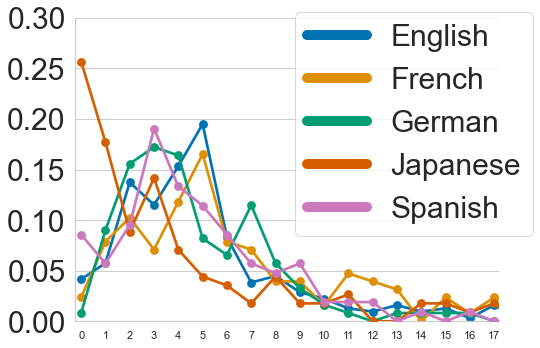

In [44]:
## Figure 3 (a) - percent rules made
_melted = pd.melt(creation_by_year_df_years_since,id_vars=['index'],value_vars=_hue_order)
g = sb.factorplot(x='index',y='value',hue='variable',data=_melted,legend=False,kind='point',
                   hue_order=_hue_order,palette='colorblind',order=range(0,20),aspect=1.5)
g.set_yticklabels(fontsize=30)
g.axes[0][0].set_xlabel('')
g.axes[0][0].set_ylabel('')
g.axes[0][0].set_ylim((0,.3))
g.axes[0][0].set_xlim((-.25,17.18))

cb_palette = sb.color_palette('colorblind',n_colors=5)

legend_elements = [Line2D([0], [0], color=cb_palette[0], lw=10),
                   Line2D([0], [0], color=cb_palette[1], lw=10),
                   Line2D([0], [0], color=cb_palette[2], lw=10),
                   Line2D([0], [0], color=cb_palette[3], lw=10),
                   Line2D([0], [0], color=cb_palette[4], lw=10)]
#plt.legend(legend_elements,_hue_order,bbox_to_anchor=(1,1),loc='upper left',fontsize=30)

plt.legend(legend_elements,_hue_order,loc='center',fontsize=30,bbox_to_anchor=(0.8,0.65))
plt.tight_layout()

g.savefig('./figs/202106_percent_rulescreated.png')

C:\Users\sohyeon\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


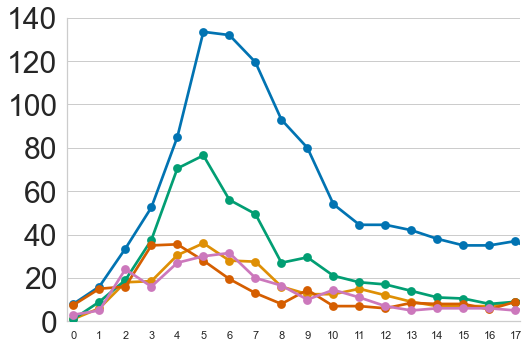

In [43]:
## Figure 3 (b) - median rule-related revisions

_dfs = []
for i,(rev_df,name) in enumerate(zip(allrev_df_list,rev_df_names)): #TODO
    #print(name)
    _df = rev_df.groupby(['creation_year','parent_page_title','year_since_first']).agg({'revid':'count'}).rename(columns={"revid":"rev_count"})['rev_count']
    _df = _df.reset_index()
    _df['lang'] = name
    _dfs.append(_df)

allrevs_year_df = pd.concat(_dfs)
allrevs_year_df = allrevs_year_df.drop(columns='parent_page_title')

# median count of all rule-related revisions (median by rule)
g = sb.factorplot(x='year_since_first',y='rev_count',hue='lang',data=allrevs_year_df.groupby(['lang','year_since_first']).agg({"rev_count":"median"}).reset_index(),
                  legend=False,kind='point',hue_order=_hue_order,palette='colorblind',order=range(0,20),aspect=1.5)
g.set_yticklabels(fontsize=30)
g.axes[0][0].set_ylabel('') #Median number of revisions to rules
g.axes[0][0].set_xlabel('')
g.axes[0][0].set_ylim((0,140))
g.axes[0][0].set_xlim((-.25,17.18))

#plt.legend(loc='center',bbox_to_anchor=(0.5,-0.3),ncol=5)
plt.tight_layout()
g.savefig('./figs/202106_number_med_rulerelatedrevs.png')

In [45]:
# for next figure, calculate activity by years
activity_by_year_df_de = pd.DataFrame()
activity_by_year_df_de['Rule activity'] = rev_df_de.groupby(['year_since_first']).agg({'revid':len})['revid'] #year
activity_by_year_df_de['Rule talk activity'] = talkrev_df_de.groupby(['year_since_first']).agg({'revid':len})['revid']

activity_by_year_df_en = pd.DataFrame()
activity_by_year_df_en['Rule activity'] = rev_df_en.groupby(['year_since_first']).agg({'revid':len})['revid']
activity_by_year_df_en['Rule talk activity'] = talkrev_df_en.groupby(['year_since_first']).agg({'revid':len})['revid']

activity_by_year_df_es = pd.DataFrame()
activity_by_year_df_es['Rule activity'] = rev_df_es.groupby(['year_since_first']).agg({'revid':len})['revid']
activity_by_year_df_es['Rule talk activity'] = talkrev_df_es.groupby(['year_since_first']).agg({'revid':len})['revid']

activity_by_year_df_fr = pd.DataFrame()
activity_by_year_df_fr['Rule activity'] = rev_df_fr.groupby(['year_since_first']).agg({'revid':len})['revid']
activity_by_year_df_fr['Rule talk activity'] = talkrev_df_fr.groupby(['year_since_first']).agg({'revid':len})['revid']

activity_by_year_df_ja = pd.DataFrame()
activity_by_year_df_ja['Rule activity'] = rev_df_ja.groupby(['year_since_first']).agg({'revid':len})['revid']
activity_by_year_df_ja['Rule talk activity'] = talkrev_df_ja.groupby(['year_since_first']).agg({'revid':len})['revid']

C:\Users\sohyeon\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


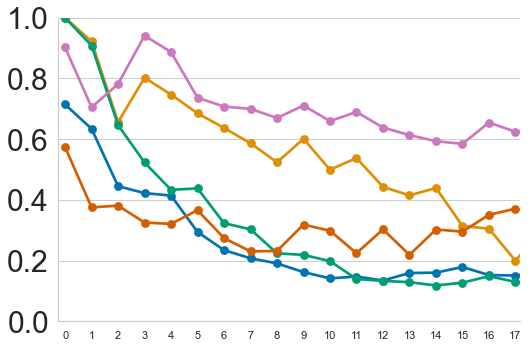

In [47]:
## Figure 3(c) - percent revisions on rule to talk

# rule page revisions : rule talk page revisions (% of rule-related revisions being on actual rule page), smoother
_activitybyyears = [activity_by_year_df_en,activity_by_year_df_fr,activity_by_year_df_de,activity_by_year_df_ja,activity_by_year_df_es]
_names = ['en','fr','de','ja','es']
rev_df_names = ['English','French','German','Japanese','Spanish']

first = True 

for i,langdf in enumerate(_activitybyyears):
    percentage = langdf["Rule activity"] / (langdf["Rule activity"] + langdf["Rule talk activity"])
    percentage_df = pd.DataFrame(percentage, columns=[rev_df_names[i]]).fillna(1.0)
    #print(percentage_df)

    if not first:
        new_df = new_df.merge(percentage_df,how='outer',on=['year_since_first'])
    else:
        new_df = percentage_df
        first = False
        #print('teehee',_names[i])

new_df.reset_index(inplace=True)
_melted = new_df.melt(id_vars=['year_since_first'],value_vars=rev_df_names)

sb.set_style('whitegrid')
g = sb.factorplot(x='year_since_first',y='value',hue='variable',data=_melted,legend=False,kind='point',
                   hue_order=_hue_order,palette='colorblind',order=range(0,20),aspect=1.5)
g.set_yticklabels(fontsize=30)
g.axes[0][0].set_ylim((0,1.0))
g.axes[0][0].set_xlim((-0.25,17.18))
g.axes[0][0].set_ylabel('') #% Revisions on Rule (vs talk) page
g.axes[0][0].set_xlabel('')
#plt.legend(loc='center',bbox_to_anchor=(0.5,-.15),ncol=5)
plt.tight_layout()
g.savefig('./figs/202106_percentrevs_rulevstalk.png')

In [48]:
# monthly - slightly more fine-grained look for calculatnig trends over the years
for rev_df in rev_df_list:
    rev_df['month'] = rev_df['date'].dt.strftime('%m')
    rev_df['month'] = pd.to_numeric(rev_df['month'])

for rev_df in talkrev_df_list:
    rev_df['month'] = rev_df['date'].dt.strftime('%m')
    rev_df['month'] = pd.to_numeric(rev_df['month'])

for rev_df in allrev_df_list:
    rev_df['month'] = rev_df['date'].dt.strftime('%m')
    rev_df['month'] = pd.to_numeric(rev_df['month'])

_index = pd.date_range(start='1/1/2001', end='12/31/2020',freq='M')
_columns = ['Y','M']
monthly_df = pd.DataFrame(index=_index, columns=_columns)
monthly_df = monthly_df.reset_index().rename(columns={"index":"datestamp"})
monthly_df['M'] = monthly_df.datestamp.dt.strftime('%m')
monthly_df['M'] = pd.to_numeric(monthly_df['M'])
monthly_df['Y'] = monthly_df.datestamp.dt.strftime('%Y')
monthly_df['Y'] = pd.to_numeric(monthly_df['Y'])

monthlytalk_df = pd.DataFrame(index=_index, columns=_columns)
monthlytalk_df = monthlytalk_df.reset_index().rename(columns={"index":"datestamp"})
monthlytalk_df['M'] = pd.to_numeric(monthlytalk_df.datestamp.dt.strftime('%m'))
monthlytalk_df['Y'] = pd.to_numeric(monthlytalk_df.datestamp.dt.strftime('%Y'))
monthlytalk_df = monthlytalk_df.drop(columns=["datestamp"])

monthlyall_df = pd.DataFrame(index=_index, columns=_columns)
monthlyall_df = monthlyall_df.reset_index().rename(columns={"index":"datestamp"})
monthlyall_df['M'] = pd.to_numeric(monthlyall_df.datestamp.dt.strftime('%m'))
monthlyall_df['Y'] = pd.to_numeric(monthlyall_df.datestamp.dt.strftime('%Y'))
monthlyall_df = monthlyall_df.drop(columns=["datestamp"])

In [49]:
## Figure 3(d) - latencies trend and diff trend

# diff
for i,(rev_df,name) in enumerate(zip(allrev_df_list,rev_df_names)):
    _df = rev_df.groupby(['year','month','parent_page_title']).agg({'diff':np.mean})
    _df = _df.groupby(['year','month']).agg({'diff':np.median})
    monthlyall_df[name] = monthlyall_df.merge(_df,how="left",left_on=["Y","M"],right_on=["year","month"])["diff"]

monthlyall_df_diff_long = monthlyall_df.melt(id_vars=['Y','M']).rename(columns={"variable":"lang","value":"median_avgdiff"})

In [50]:
# lag
monthlyall_df = pd.DataFrame(index=_index, columns=_columns)
monthlyall_df = monthlyall_df.reset_index().rename(columns={"index":"datestamp"})
monthlyall_df['M'] = pd.to_numeric(monthlyall_df.datestamp.dt.strftime('%m'))
monthlyall_df['Y'] = pd.to_numeric(monthlyall_df.datestamp.dt.strftime('%Y'))
monthlyall_df = monthlyall_df.drop(columns=["datestamp"])

for i,(rev_df,name) in enumerate(zip(allrev_df_list,rev_df_names)):
    _df = rev_df.groupby(['year','month','parent_page_title']).agg({'lag':np.mean})
    _df = _df.groupby(['year','month']).agg({'lag':np.median})
    monthlyall_df[name] = monthlyall_df.merge(_df,how="left",left_on=["Y","M"],right_on=["year","month"])["lag"]

monthlyall_df_lag_long = monthlyall_df.melt(id_vars=['Y','M']).rename(columns={"variable":"lang","value":"median_avglag"})

In [51]:
monthlyall_df_diff_long = monthlyall_df_diff_long.groupby(['lang','Y']).agg({'median_avgdiff':np.median}).reset_index()
monthlyall_df_lag_long = monthlyall_df_lag_long.groupby(['lang','Y']).agg({'median_avglag':np.median}).reset_index()
monthlyall_df_long = monthlyall_df_lag_long.merge(monthlyall_df_diff_long,how="left",left_on=['Y','lang'],right_on=['Y','lang'])

In [52]:
def get_year_since(row):
    if row['lang'] == "Japanese":
        return row['Y'] - 2003
    else:
        return row['Y'] - 2001

monthlyall_df_long['Y'] = monthlyall_df_long.apply(get_year_since,axis=1)

C:\Users\sohyeon\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


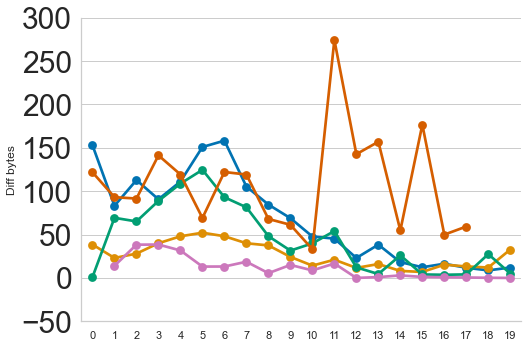

In [53]:
g = sb.factorplot(x='Y',y='median_avgdiff',hue='lang',data=monthlyall_df_long,legend=False,kind='point',ci=None,hue_order=_hue_order,palette='colorblind',order=range(0,20),aspect=1.5)
g.set_yticklabels(fontsize=30)
g.set_axis_labels("","Diff bytes")
plt.tight_layout()

In [54]:
# to try -- did not use though
monthlyall_df_long['log_median_avglag'] = np.log(monthlyall_df_long.median_avglag)

C:\Users\sohyeon\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


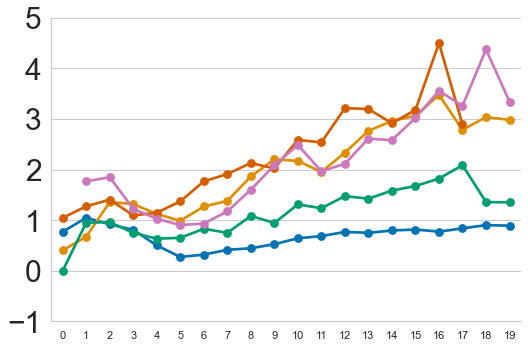

In [55]:
g = sb.factorplot(x='Y',y='median_avglag',hue='lang',data=monthlyall_df_long,legend=False,kind='point',#ci=None,
                  hue_order=_hue_order,palette='colorblind',order=range(0,20),aspect=1.5)
g.set_yticklabels(fontsize=30)
g.set_axis_labels("","")
plt.tight_layout()

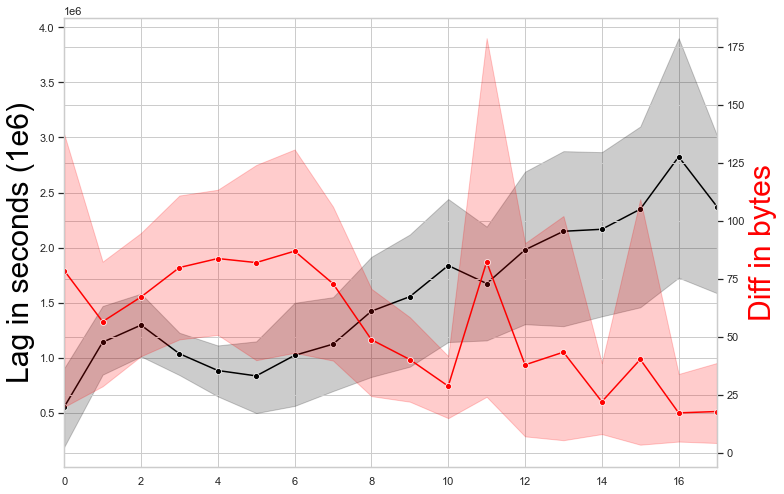

In [81]:
## actually making 3(d)

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sb.lineplot(x='Y',y='median_avglag',data=monthlyall_df_long,marker = 'o',ax = ax1, color = 'black')
sb.lineplot(x='Y',y='median_avgdiff',data=monthlyall_df_long,marker = 'o',ax = ax2, color = 'red')

# these lines add the annotations for the plot. 

ax1.set_xlim((0,17))
ax1.set_xlabel('')
ax1.set_ylabel('Lag in seconds (1e6)', color='black',fontsize=30)

#ax2.set_yticklabels(labels=[0,25,50,75,100,125,150,175],fontsize=15)
ax2.set_ylabel('Diff in bytes', color='red',fontsize=30)

plt.show(); # shows the plot. 

fig.savefig('./figs/202106_laganddiff_trend.png')

In [82]:
## Figure 4

#early, growth, decline
custom_cmap = [(0.20973515, 0.09747934, 0.24238489),(0.20973515, 0.09747934, 0.24238489),(0.20973515, 0.09747934, 0.24238489),(0.43860848, 0.12177004, 0.34119475),(0.43860848, 0.12177004, 0.34119475),(0.43860848, 0.12177004, 0.34119475),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148),(0.67824099, 0.09192342, 0.3504148)]

In [83]:
def get_total_revs_that_year(row):
    y = row.year_since_first
    #print(total_revs_in_year)
    return total_revs_in_year['revid'][y]

0 English
1 French
2 German
3 Japanese
<ipython-input-89-d0d21516e75d>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-89-d0d21516e75d>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-89-d0d21516e75d>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
4 Spanish
<ipython-input-89-d0d21516e75d>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])


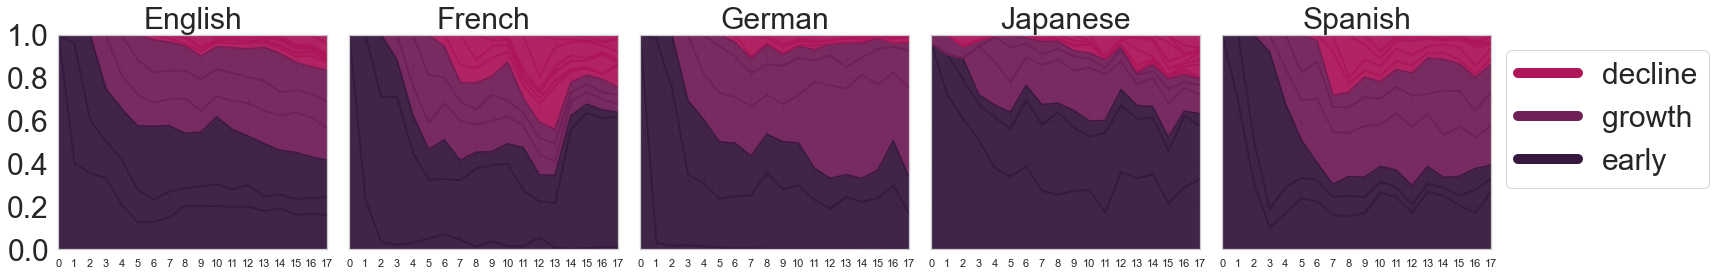

In [89]:
# early, growth, decline

f,axs = plt.subplots(1,5,figsize=(24,4))

for i,(rev_df,name) in enumerate(zip(allrev_df_list,rev_df_names)):
    print(i,name)
    _df = rev_df.groupby(['creation_year','page','year_since_first']).agg({'revid':len})['revid']
    _df = _df.mean(level=['creation_year','year_since_first']).unstack('creation_year')#.fillna(method='ffill') # .cumsum() before fillna
    _df = _df.reindex(columns=range(0,20))

    _df = rev_df.groupby(['creation_year','parent_page_title','year_since_first']).agg({'revid':"count"})['revid']
    _df = _df.reset_index()
    _df['lang'] = name
    total_revs_in_year = _df.groupby(['year_since_first']).agg({'revid':sum}).to_dict()
    _df['total_revs_yearly'] = _df.apply(get_total_revs_that_year,axis=1)

    _df["percentage_revs"] = _df.revid.astype(np.float32) / _df.total_revs_yearly.astype(np.float32)
    _df = _df.groupby(["lang","year_since_first","creation_year"]).agg({"percentage_revs":"sum"}).reset_index()
    _df = _df.pivot(index="year_since_first",columns="creation_year",values="percentage_revs")

    #print(_df)

    _df.plot(kind='area',stacked=True,legend=False,alpha=0.95,ax=axs[i],color=custom_cmap)

    axs[i].set_xticks(range(0,20))
    axs[i].set_xticklabels(range(0,20))
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')

    if name == "Japanese":
        axs[i].set_xticks(range(0,20))
        axs[i].set_xlim(0,17)
    elif name == "Spanish":
        axs[i].set_xticks(range(0,20))
        axs[i].set_xlim(0,17)
    else:
        axs[i].set_xticks(range(0,20))
        axs[i].set_xlim(0,17)
    axs[i].set_xticklabels(range(0,20))
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')
    axs[i].set_ylim(0,1)

    if i == 0:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        axs[i].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        axs[i].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=30)

    else:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        axs[i].set_yticklabels(["","","","","",""])

#axs[0].set_ylabel('Percent of revisions to a rule created in X era')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=(0.67824099, 0.09192342, 0.3504148), lw=10),
                   Line2D([0], [0], color=(0.43860848, 0.12177004, 0.34119475), lw=10),
                   Line2D([0], [0], color=(0.20973515, 0.09747934, 0.24238489), lw=10)]
#f.legend(legend_elements,['early','growth','decline'],bbox_to_anchor=(1,1),loc='upper left',ncol=3)
plt.legend(legend_elements,['decline','growth','early'],bbox_to_anchor=(1,1),loc='upper left',fontsize=30)
f.tight_layout()
f.savefig("./figs/202106_percent_revisions_eras.png")

## Figures (RQ2)

First, we get rules' ILLs

In [90]:
# get ILLs

ills = {}

rules_df_de = rules_df_de.rename(columns={0: "NA", 1: "links",2:"titles"})
rules_df_en = rules_df_en.rename(columns={0: "NA", 1: "links", 2: "titles", 3:"shortcuts"})
rules_df_es = rules_df_es.rename(columns={0: "NA", 1: "links", 2: "titles", 3:"shortcuts"})
rules_df_fr = rules_df_fr.rename(columns={0: "NA", 1: "links", 2: "titles", 3:"shortcuts"})
rules_df_ja = rules_df_ja.rename(columns={0: "NA", 1: "links", 2: "titles", 3:"shortcuts"})

rules_dfs = [rules_df_de,rules_df_en,rules_df_es,rules_df_fr,rules_df_ja]
rules_dfs_dict = {'de':rules_df_de,'en':rules_df_en,'es':rules_df_es,'fr':rules_df_fr,'ja':rules_df_ja}

In [91]:
for l in langs:
    rules_dfs_dict[l]['lang'] = l

rules_to_langs = pd.concat([rules_dfs_dict['de'].drop(columns=['NA','links']),
                            rules_dfs_dict['en'].drop(columns=['NA','links','shortcuts']),
                            rules_dfs_dict['es'].drop(columns=['NA','links','shortcuts']),
                            rules_dfs_dict['fr'].drop(columns=['NA','links','shortcuts']),
                            rules_dfs_dict['ja'].drop(columns=['NA','links','shortcuts'])])

In [92]:
rule_ills = pd.read_csv('202104_rules_withillcolumns',sep='\t')

In [93]:
rule_ills.loc[rule_ills.page=="Wikipedia:Spam"]

,page,creation_year,num_links,de,en,es,fr,ja,rc
397,Wikipedia:Spam,2003,3,NaN,Wikipedia:Spam,Wikipedia:Spam,Wikipédia:Spam,NaN,437.0
524,Wikipedia:Spam,2006,3,NaN,Wikipedia:Spam,Wikipedia:Spam,Wikipédia:Spam,NaN,437.0


In [94]:
# manually correcting errors
rule_ills.loc[rule_ills.page == "Wikipedia:No disclaimers in articles", 'num_links'] = 2
rule_ills.loc[rule_ills.page == "Wikipedia:No disclaimers in articles", 'en'] = "Wikipedia:No disclaimers in articles"
rule_ills.loc[rule_ills.page == "Wikipedia:No disclaimers in articles", "ja"] = "Wikipedia:記事に免責事項を載せない"

rule_ills.loc[rule_ills.page == "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide", 'num_links'] = 1
rule_ills.loc[rule_ills.page == "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide", 'en'] = "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide"
rule_ills.loc[rule_ills.page == "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide"]

,page,creation_year,num_links,de,en,es,fr,ja,rc
413,Wikipedia:Trinidad and Tobago Wikipedians' not...,2011,1,NaN,Wikipedia:Trinidad and Tobago Wikipedians' not...,NaN,NaN,NaN,NaN


In [95]:
for x in rules_to_langs.titles.values.tolist():
    if x not in rule_ills.page.values.tolist():
        print(x)
        # these are the pages we're missing in 202104_rules_withillcolumns. the difference is the name has changed so we want to update

Wikipedia:Anarchism referencing guidelines
Wikipedia:Naming conventions (long lists)
Wikipedia:Manual of Style/Anime- and manga-related articles
Wikipedia:Manual of Style/Philippine-related articles
Aide:Contributions rémunérées
Wikipédia:Jouer avec les principes, règles et recommandations de Wikipédia
Wikipédia:Supposer la bonne foi
Wikipédia:Toujours commenter vos modifications dans la boîte de résumé
Aide:Travailler collectivement
Wikipédia:Usage raisonné des sources de presse
Wikipedia:オープンプロクシは使わない
Wikipedia:自分自身の記事をつくらない
Wikipedia:外部リンクの選び方


In [96]:
ill_name_update = {"Wikipedia:Anarchism referencing guidelines":"Wikipedia:WikiProject Anarchism","Wikipedia:Naming conventions (long lists)":"Wikipedia:Naming conventions (lists)",
                    "Wikipedia:Manual of Style/Anime- and manga-related articles":"Wikipedia:Manual of Style/Anime and manga",
                    "Wikipedia:Manual of Style/Philippine-related articles":"Wikipedia:Manual of Style/Philippines-related articles",
                    "Aide:Contributions rémunérées":"Wikipédia:Contributions rémunérées","Wikipédia:Jouer avec les principes, règles et recommandations de Wikipédia":"Wikipédia:Ne jouez pas avec les règles",
                    "Wikipédia:Supposer la bonne foi":"Wikipédia:Supposez la bonne foi","Wikipédia:Toujours commenter vos modifications dans la boîte de résumé":"Wikipédia:Commentez vos modifications",
                    "Aide:Travailler collectivement":"Wikipédia:Travailler collectivement","Wikipédia:Usage raisonné des sources de presse":"Wikipédia:Sources de presse",
                    "Wikipedia:オープンプロクシは使わない":"Wikipedia:公開プロキシの規制","Wikipedia:自分自身の記事をつくらない":"Wikipedia:自分自身の記事","Wikipedia:外部リンクの選び方":"Wikipedia:外部リンク"}

ill_name_update_reverse = {v: k for k, v in ill_name_update.items()}

In [97]:
def update_name(row):
    name = row['titles']
    if name in list(ill_name_update.keys()):
        name = ill_name_update[name]
    return name

In [98]:
rules_to_langs['titles'] = rules_to_langs.apply(update_name,axis=1)

In [99]:
# quick check
for x in rule_ills.page.values.tolist():
    if x not in rules_to_langs.titles.values.tolist():
        print(x)

In [100]:
len(rules_to_langs.titles.values.tolist()), len(rule_ills.page.values.tolist())

(780, 780)

In [101]:
rules_to_langs.loc[rules_to_langs.titles=="Wikipedia:Spam"]

,titles,lang
99,Wikipedia:Spam,en
58,Wikipedia:Spam,es


```
def get_interlanguage_links(page_title, endpoint='en.wikipedia.org/w/api.php', redirects=1, multicore_dict=None):
    """The function accepts a page_title and returns a dictionary containing 
    the title of the page in its other languages
       
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
       
    Returns:
    langlink_dict - a dictionary keyed by lang codes and page title as values
    """
    
    #query_string = "https://{1}.wikipedia.org/w/api.php?action=query&format=json&prop=langlinks&formatversion=2&titles={0}&llprop=autonym|langname&lllimit=500".format(page_title,lang)
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['prop'] = 'langlinks'
    query_params['titles'] = page_title
    query_params['redirects'] = redirects
    query_params['llprop'] = 'autonym|langname'
    query_params['lllimit'] = 500
    query_params['format'] = 'json'
    query_params['formatversion'] = 2
    json_response = requests.get(url=query_url,params=query_params).json()
    #print(json_response)
    
    interlanguage_link_dict = dict()
    start_lang = endpoint.split('.')[0]
    #print(json_response['query']['pages'][0])
    if 'title' in json_response['query']['pages'][0]:
        final_title = json_response['query']['pages'][0]['title']
        interlanguage_link_dict[start_lang] = final_title
    else:
        final_title = page_title
        interlanguage_link_dict[start_lang] = final_title

    if 'langlinks' in json_response['query']['pages'][0]:
        langlink_dict = json_response['query']['pages'][0]['langlinks']

        for d in langlink_dict:
            lang = d['lang']
            title = d['title']
            interlanguage_link_dict[lang] = title
            
    if multicore_dict is None:
        return {final_title:interlanguage_link_dict}
    else:
        multicore_dict[final_title] = interlanguage_link_dict
```

```
test_ills = dict()
endpoint = "{}.wikipedia.org/w/api.php".format('de')
p = 'Wikipedia:Neutraler Standpunkt'
testtemp = get_interlanguage_links(p,endpoint)
```

```
for lang in langs:
    print(lang)
    endpoint = "{}.wikipedia.org/w/api.php".format(lang)
    df = rules_dfs_dict[lang]
    pagetitles = df["titles"].tolist()

    temp = {}
    prev = ""
    for p in sorted(pagetitles):
        #print(p)

        if p == prev:
            print("\n","Error! A repeat: ",p)
        prev = p

        try:
            temp.update(get_interlanguage_links(p,endpoint))
        except KeyboardInterrupt:
            break
        except:
            print('!!! FAILED > {}'.format(p))
            pass

    ills[lang] = temp

# test
print(len(ills['ja']))
ills['es']['Wikipedia:Acerca de firmar artículos']
```

```
# manipulate ILL data

def get_ills_aslist_fullname(langlinks_dict):
    '''
    Takes in the langlinks dict and returns a dictionary that has page titles as keys and a list of ILL language codes + page name as values.
    '''
    ill_list = dict()
    for pagekey in langlinks_dict.keys():
        _temp = list()
        for langkey in langlinks_dict[pagekey]:
            if langkey in langs: #filter for the langs. if we want to get all, just remove this line and unindent following line
                _temp.append("{}:{}".format(langkey,langlinks_dict[pagekey][langkey]))
        ill_list[pagekey] = _temp
    return ill_list

def get_ills_aslist(langlinks_dict):
    '''
    Takes in the langlinks dict and returns a dictionary that has page titles as keys and a list of ILL language codes as values.
    '''
    ill_list = dict()
    for pagekey in langlinks_dict.keys():
        _temp = list()
        for langkey in langlinks_dict[pagekey]:
            if langkey in langs: #filter for the langs. if we want to get all, just remove this line and unindent following line
                _temp.append(langkey)
        ill_list[pagekey] = _temp
    return ill_list
```

In [102]:
rules_to_langs_dict = pd.Series(rules_to_langs.lang.values,index=rules_to_langs.titles).to_dict()

def find_lang(row):
    if row['page'] == "Wikipedia:Spam":
        if row['creation_year'] == 2003 or row['creation_year'] == '2003':
            return 'en'
        else:
            return 'es'
    return rules_to_langs_dict[row['page']]

In [103]:
rule_ills['lang'] = rule_ills.apply(find_lang,axis=1)

In [104]:
def get_ills_aslist_fullname_fromdf(row):
    out = []
    _langs = ['de', 'en', 'es', 'fr', 'ja']
    for _l in _langs:
        if not pd.isna(row[_l]):
            stringed = "{}:{}".format(_l,row[_l])
            out.append(stringed)
    return out

def get_ills_aslist_fromdf(row):
    _langs = ['de', 'en', 'es', 'fr', 'ja']
    out = []
    for _l in _langs:
        if not pd.isna(row[_l]):
            out.append(_l)
    return out

In [105]:
rule_ills['link_list_name'] = rule_ills.apply(get_ills_aslist_fullname_fromdf,axis=1)
rule_ills['link_list'] = rule_ills.apply(get_ills_aslist_fromdf,axis=1)

In [106]:
rule_ills

,page,creation_year,num_links,de,en,es,fr,ja,rc,lang,link_list_name,link_list
0,Portal:Antarktis/Konventionen,2017,1,Portal:Antarktis/Konventionen,NaN,NaN,NaN,NaN,14.0,de,[de:Portal:Antarktis/Konventionen],[de]
1,Portal:Bahn/Anforderungen an Bahnartikel,2006,3,Portal:Bahn/Anforderungen an Bahnartikel,Wikipedia:WikiProject Trains/Style advice,Wikiproyecto:Ferrocarriles/Convenciones y estilos,NaN,NaN,15.0,de,"[de:Portal:Bahn/Anforderungen an Bahnartikel, ...","[de, en, es]"
2,Portal:Bergbau/Namenskonventionen,2015,1,Portal:Bergbau/Namenskonventionen,NaN,NaN,NaN,NaN,16.0,de,[de:Portal:Bergbau/Namenskonventionen],[de]
3,Portal:Berge und Gebirge/Relevanzkriterien und...,2008,1,Portal:Berge und Gebirge/Relevanzkriterien und...,NaN,NaN,NaN,NaN,17.0,de,[de:Portal:Berge und Gebirge/Relevanzkriterien...,[de]
4,Portal:Hund/Leitlinien,2009,1,Portal:Hund/Leitlinien,NaN,NaN,NaN,NaN,18.0,de,[de:Portal:Hund/Leitlinien],[de]
...,...,...,...,...,...,...,...,...,...,...,...,...
775,Wikipedia:関連作品,2009,1,NaN,NaN,NaN,NaN,Wikipedia:関連作品,537.0,ja,[ja:Wikipedia:関連作品],[ja]
776,Wikipedia:関連項目,2006,2,NaN,Wikipedia:See also,NaN,NaN,Wikipedia:関連項目,432.0,ja,"[en:Wikipedia:See also, ja:Wikipedia:関連項目]","[en, ja]"
777,Wikipedia:雑多な内容を箇条書きした節を避ける,2007,4,NaN,Wikipedia:Manual of Style/Trivia sections,Wikipedia:Manual de estilo/Secciones de curios...,Wikipédia:Sections anecdotiques,Wikipedia:雑多な内容を箇条書きした節を避ける,327.0,ja,"[en:Wikipedia:Manual of Style/Trivia sections,...","[en, es, fr, ja]"
778,プロジェクト:キリスト教/キリスト教の記事名と用語表記のガイドライン,2014,1,NaN,NaN,NaN,NaN,プロジェクト:キリスト教/キリスト教の記事名と用語表記のガイドライン,538.0,ja,[ja:プロジェクト:キリスト教/キリスト教の記事名と用語表記のガイドライン],[ja]


In [107]:
rule_interlanguagelinks_names = dict()
rule_interlanguagelinks = dict()

for _lang in langs:
    print(_lang)
    _temp = rule_ills.loc[rule_ills.lang == _lang]
    rule_interlanguagelinks[_lang] = pd.Series(_temp.link_list.values,index=_temp.page).to_dict()
    rule_interlanguagelinks_names[_lang] = pd.Series(_temp.link_list_name.values,index=_temp.page).to_dict()

de
en
es
fr
ja


```
rule_interlanguagelinks_names = dict()
rule_interlanguagelinks = dict()

for lang in langs:
    print(lang)
    rule_interlanguagelinks[lang] = get_ills_aslist(ills[lang])
    rule_interlanguagelinks_names[lang] = get_ills_aslist_fullname(ills[lang])
```

In [108]:
## rule set overlap viz
all_links = []

for lang in langs:
    print(lang, len(rule_interlanguagelinks[lang]))
    all_links = all_links + list(rule_interlanguagelinks[lang].values())

num_ills = []
for x in all_links:
    num_ills.append(len(x))

all_links = ['_'.join(sorted(x)) for x in all_links]
all_links_counter = Counter(all_links)

print(sum(all_links_counter.values()))

all_links_counter_percent = {}
for k in all_links_counter:
    all_links_counter_percent[k] = all_links_counter[k] / sum(all_links_counter.values())

de 122
en 313
es 105
fr 127
ja 113
780


In [109]:
venn_dict = {"English":set(),"French":set(),"German":set(),"Japanese":set(),"Spanish":set()}
shortcut_dict = {"en":"English","de":"German","es":"Spanish","fr":"French","ja":"Japanese"}

rule_interlanguagelinks['de']

for lang in langs:
    print(lang, len(rule_interlanguagelinks[lang]))
    for r in rule_interlanguagelinks[lang]:
        links = rule_interlanguagelinks[lang][r]
        links_long = [shortcut_dict[l] for l in links]
        for l in links_long:
            if l not in venn_dict:
                venn_dict[l] = set()
            venn_dict[l].add(r)

de 122
en 313
es 105
fr 127
ja 113


In [110]:
len(dict(all_links_counter)), len(venn_dict)

(24, 5)

In [111]:
Counter(num_ills)

Counter({1: 259, 3: 89, 2: 100, 4: 111, 5: 221})

In [113]:
!{sys.executable} -m pip install venn

  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=36adf45b8c62a290f9ecd388b2cc86719ac8b04ea5c19da9190b9b69e28de361
  Stored in directory: c:\users\sohyeon\appdata\local\pip\cache\wheels\00\af\db\bff429be06f7356f58630ec42391f77653b67595e2d068d348
Successfully built venn


<AxesSubplot:>

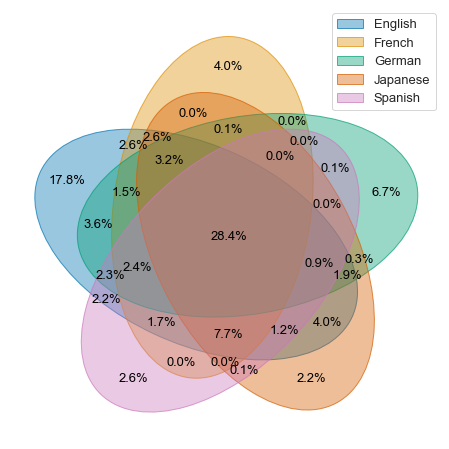

In [114]:
#!{sys.executable} -m pip install venn
from venn import venn
venn(venn_dict,cmap=sb.color_palette('colorblind',n_colors=5),fmt="{percentage:.1f}%")

<AxesSubplot:>

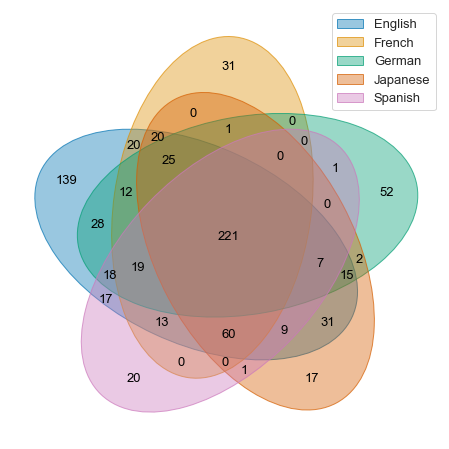

In [115]:
venn(venn_dict,cmap=sb.color_palette('colorblind',n_colors=5))

In [116]:
# pages are not 1-1 mappings. and a rule in some language edition might have a page that ILL to a page on another but isn't a 'rule' or is connecting back to another rule page. so we create 'rule concepts' and check where these rule concepts are.
# calculate rule concept overlaps
all_rulenames = []
all_ill_rulenames = []
rule_concepts = []

for lang in langs:
    fixed_rules = ["{}:{}".format(lang,_temp) for _temp in rule_interlanguagelinks_names[lang].keys()]
    all_rulenames += fixed_rules
    for x in list(rule_interlanguagelinks_names[lang].values()):
        #print(len(rule_interlanguagelinks_names[lang]),x)
        rule_concepts.append(x)
        all_ill_rulenames = all_ill_rulenames + x

rule_concepts = [sorted(x) for x in rule_concepts]
rule_concepts = sorted(rule_concepts)

#print(set(Counter(all_rulenames).values()))

In [117]:
len(all_rulenames), len(all_ill_rulenames), len(set(Counter(all_ill_rulenames).keys())) # this number is larger than the number of rules because not all of the ILLd "rules" on the other wikis

(780, 2275, 1165)

In [118]:
unmerged_concepts = []
merged_concepts = []

for ia,concept_a in enumerate(rule_concepts):
    for ib,concept_b in enumerate(rule_concepts):
        if ia == ib:
            if concept_a != concept_b:
                print("Error? The two concepts should match.")
            else:
                merged_concepts.append(concept_a)
        else:
            if concept_a == concept_b:
                continue
            # find set overlap
            intersect = set(concept_a) & set(concept_b)
            if len(intersect) != 0:
                unmerged_concepts.append(concept_a)
                unmerged_concepts.append(concept_b)
                merged_concepts.append(sorted(list(set(concept_a) | set(concept_b))))        

In [119]:
rule_concepts_set = []

for x in merged_concepts:
    if x not in rule_concepts_set:
        rule_concepts_set.append(x)

len(rule_concepts_set)

539

In [120]:
rule_concepts_lengths = []

for rc in rule_concepts_set:
    rule_concepts_lengths.append(len(rc))
    if len(rc)==9:
        print(rc)

Counter(rule_concepts_lengths)

['de:Wikipedia:Geschützte Seiten', 'en:Wikipedia:Protected page', 'en:Wikipedia:Protection policy', 'es:Wikipedia:Esta página está protegida', 'es:Wikipedia:Política de protección', 'fr:Wikipédia:Niveaux de protection', 'fr:Wikipédia:Page protégée', 'ja:Wikipedia:保護されたページ', 'ja:Wikipedia:保護の方針']


Counter({5: 74, 3: 62, 4: 60, 1: 259, 2: 79, 6: 4, 9: 1})

In [121]:
rule_concepts_dict = {}
rc = 0

for x in rule_concepts_set:
    rule_concepts_dict[rc] = x
    rc += 1

In [122]:
rule_concepts_langdict = {}

for x in rule_concepts_dict.keys():
    pages = rule_concepts_dict[x]
    ls = [_p[:2] for _p in pages]
    rule_concepts_langdict[x] = ls

In [123]:
rule_concepts_venn = {'English':set(), 'French':set(), 'Japanese':set(), 'German':set(), 'Spanish':set() }
for x in rule_concepts_langdict:
    for lang in ['de','en','es','fr','ja']:
        if lang in rule_concepts_langdict[x]:
            rule_concepts_venn[shortcut_dict[lang]].add(x)

<AxesSubplot:>

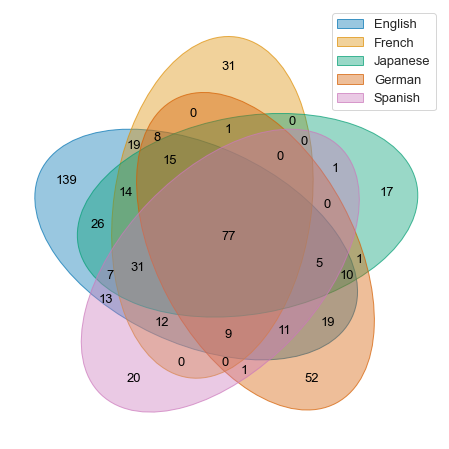

In [124]:
venn(rule_concepts_venn,cmap=sb.color_palette('colorblind',n_colors=5))#,fmt="{percentage:.1f}%")

<AxesSubplot:>

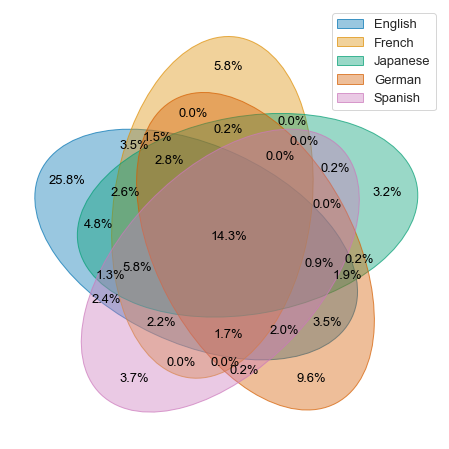

In [125]:
venn(rule_concepts_venn,cmap=sb.color_palette('colorblind',n_colors=5),fmt="{percentage:.1f}%")

    rule_concepts_langdict_stringified = {}
    for x in rule_concepts_langdict:
        rule_concepts_langdict_stringified[x] = "_".join(sorted(list(set(rule_concepts_langdict[x])))) 

    rule_concepts_langdict_stringified_reversed = {}

    for x in rule_concepts_langdict_stringified:
        if rule_concepts_langdict_stringified[x] not in rule_concepts_langdict_stringified_reversed:
            rule_concepts_langdict_stringified_reversed[rule_concepts_langdict_stringified[x]] = []
        rule_concepts_langdict_stringified_reversed[rule_concepts_langdict_stringified[x]].append(x)

    rule_concepts_langdict_stringified_reversed_len = {}
    for x in rule_concepts_langdict_stringified_reversed.keys():
        rule_concepts_langdict_stringified_reversed_len[x] = len(rule_concepts_langdict_stringified_reversed[x])

    rule_concepts_langdict_stringified_reversed_len

    count_rule_occurence = {}

    for rule in all_rulenames:
        if rule not in count_rule_occurence:
            count_rule_occurence[rule] = 0
        for lang in langs:
            for list_of_illdpagesrules in list(rule_interlanguagelinks_names[lang].values()):
                if rule in list_of_illdpagesrules:
                    count_rule_occurence[rule] += 1

In [126]:
langs

['de', 'en', 'es', 'fr', 'ja']

    for lang in langs:
        for rule in rule_interlanguagelinks[lang]:
            if len(rule_interlanguagelinks[lang][rule]) == 0:
                print(rule)

In [127]:
## all 4 ILLs and 0 ILLs
all_ills = []
no_ills = []

for lang in langs:
    for rule in rule_interlanguagelinks[lang]:
        if set(['en','es','de','fr','ja']) == set(rule_interlanguagelinks[lang][rule]):
            all_ills.append([lang,rule])
        elif len(rule_interlanguagelinks[lang][rule]) == 1:
            no_ills.append([lang,rule])

len(all_ills), len(no_ills)

(221, 259)

We exported a list of rules with their numebr of revisions and their unique contributors, for rules with 0 and 4 ILLs (not including linked to itself)

```
# number of revisions
def get_num_revisions(row):
    lang = row["0"]
    page = row["1"]
    revs = pd.concat(wf.get_all_page_revisions(page, endpoint='{}.wikipedia.org/w/api.php'.format(lang)))
    return len(revs)

# number of unique contributors
def get_num_ucs(row):
    lang = row["0"]
    page = row["1"]
    revs = pd.concat(wf.get_all_page_revisions(page, endpoint='{}.wikipedia.org/w/api.php'.format(lang)))
    revs = revs.groupby(['user']).agg({"revid":"count"}).reset_index()
    return len(revs)

all_ills = pd.read_csv('ills_all.tsv',sep='\t')
none_ills = pd.read_csv('ills_none_updated.tsv',sep='\t')

all_ills['number_revisions'] = all_ills.apply(get_num_revisions,axis=1)
all_ills['number_unique_users'] = all_ills.apply(get_num_ucs,axis=1)
none_ills['number_revisions'] = none_ills.apply(get_num_revisions,axis=1)
none_ills['number_unique_users'] = none_ills.apply(get_num_ucs,axis=1)

#all_ills['first_year']= all_ills.apply(get_first_year,axis=1)
#none_ills['first_year']= all_ills.apply(get_first_year,axis=1)

```

Serene did some more metadata checking, and now we want to import that file.

    none_ills.to_csv('ills_none_updated.tsv',sep='\t',index=False)
    all_ills.to_csv('ills_all_updated.tsv',sep='\t',index=False)

    # exported to share with serene for some metadata coding

In [136]:
!{sys.executable} -m pip install openpyxl

In [137]:
## import serene's file
all_and_none = pd.read_excel("ills_all_and_none_reformatted.xlsx",engine='openpyxl')
all_and_none = all_and_none.merge(rule_ills[['page','creation_year']],how="left",left_on="Rule Name",right_on="page")
all_ills = all_and_none.loc[all_and_none["ILLs in Set"] == 4]
none_ills = all_and_none.loc[all_and_none["ILLs in Set"] == 0]

In [138]:
for p in none_ills["Rule Name"].values.tolist():
    if p not in rule_ills.loc[rule_ills.num_links == 1].page.values.tolist():
        print(p)

"Wikipedia:WikiProject Trinidad and Tobago/Style guide" is the page that "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide" redirects to.

In [139]:
rule_ills.loc[rule_ills.page == "Wikipedia:Trinidad and Tobago Wikipedians' notice board/Style guide", "page"] = "Wikipedia:WikiProject Trinidad and Tobago/Style guide"
#rule_ills.loc[rule_ills.page.str.contains("Trinidad")]

In [140]:
# descriptive statistics
print("""Simple descriptive statistics / comparing all ILLs and no ILLs

         MEAN REVISIONS       MEDIAN REVISIONS    MEAN CONTRIBUTORS       MED. CONTRIBUTORS       
0 ILLs:  {}   {}                {}       {}
4 ILLs:  {}    {}               {}      {}
""".format(none_ills["number_revisions"].mean(),none_ills["number_revisions"].median(),
           none_ills["number_unique_users"].mean(),none_ills["number_unique_users"].median(),
           all_ills["number_revisions"].mean(),all_ills["number_revisions"].median(),
           all_ills["number_unique_users"].mean(),all_ills["number_unique_users"].median() ))

Simple descriptive statistics / comparing all ILLs and no ILLs

         MEAN REVISIONS       MEDIAN REVISIONS    MEAN CONTRIBUTORS       MED. CONTRIBUTORS       
0 ILLs:  176.06177606177607   85.0                69.85328185328186       35.0
4 ILLs:  924.0316742081448    328.0               367.81900452488685      161.0



In [141]:
rule_ills.groupby(['num_links']).mean()

,creation_year,rc
num_links,,
1,2007.617761,344.240310
2,2006.810000,246.000000
3,2006.629213,224.168539
4,2006.495495,233.387387
5,2004.452489,113.425339


In [142]:
#all_ills["number_revisions"].plot(kind='hist')
# sb.displot(data=all_and_none,x='number_revisions',hue='ILLs in Set',col='Language',kind="kde")
# we see the distributions are skewed, so median is the better measure of comparison / summarizing

In [143]:
924.0316742081448/176.06177606177607, 328.0/85.0, 367.81900452488685/69.85328185328186, 161.0/35.0

(5.2483377986822255, 3.8588235294117648, 5.265593752594832, 4.6)

Rules with 4 ILLs have 3.86X more revisions and 4.6X more unique contributors than those with no ILLs.

<AxesSubplot:xlabel='number_revisions', ylabel='number_unique_users'>

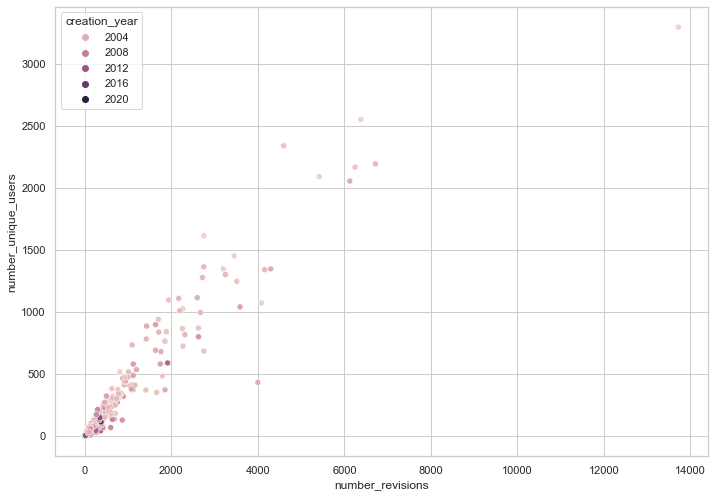

In [144]:
sb.scatterplot(data=all_and_none,x="number_revisions",y="number_unique_users",hue="creation_year")

Number of revisions and number of unique contributors is positively correlated.

## Some figures of number of rules and rule-page revisions over the years grouped by number of ILLs those rules have

In [145]:
creation_year_en_df = pd.DataFrame()
creation_year_en_df[['page','creation_year']] = rev_df_en[['page','creation_year']]
creation_year_en_df.drop_duplicates(inplace=True)

creation_year_es_df = pd.DataFrame()
creation_year_es_df[['page','creation_year']] = rev_df_es[['page','creation_year']]
creation_year_es_df.drop_duplicates(inplace=True)

creation_year_fr_df = pd.DataFrame()
creation_year_fr_df[['page','creation_year']] = rev_df_fr[['page','creation_year']]
creation_year_fr_df.drop_duplicates(inplace=True)

creation_year_de_df = pd.DataFrame()
creation_year_de_df[['page','creation_year']] = rev_df_de[['page','creation_year']]
creation_year_de_df.drop_duplicates(inplace=True)

creation_year_ja_df = pd.DataFrame()
creation_year_ja_df[['page','creation_year']] = rev_df_ja[['page','creation_year']]
creation_year_ja_df.drop_duplicates(inplace=True)

creation_year_dfs = [creation_year_en_df,creation_year_fr_df,creation_year_de_df,creation_year_ja_df,creation_year_es_df]

In [146]:
rule_concepts_dict_reverse = {}

for x in rule_concepts_dict.keys():
    for n in rule_concepts_dict[x]:
        rule_concepts_dict_reverse[n[3:]] = x

In [147]:
def find_ruleconcept(row):
    rule = row['page']
    if rule in rule_concepts_dict_reverse.keys():
        return rule_concepts_dict_reverse[rule]
    else:
        # we don't have a rule concept assigned to this page
        print(rule)
        return None

In [148]:
langs = ['en', 'fr', 'de', 'ja', 'es']

In [149]:
for i,_df in enumerate(creation_year_dfs):
    print(i,langs[i])
    _df["lang"] = langs[i]

    #INITIALIZE
    _df["num_links"] = 0

    for lang in langs:
        _df[lang] = ""
    
    #SET VALUE
    for r in rule_interlanguagelinks[langs[i]]:
        links = rule_interlanguagelinks_names[langs[i]][r]
        links_lang = [_l[:2] for _l in links]
        _df.loc[_df.page == r,["num_links"]] = len(links)

        for l in links_lang:
            for linkname in links:
                if l == linkname[:2]:
                    _df.loc[_df.page == r,[l]] = linkname[3:]

    #MAP TO RULE CONCEPT
    _df['rc'] = _df.apply(find_ruleconcept,axis=1)

0 en
1 fr
2 de
3 ja
4 es


In [150]:
_df.head(2)

,page,creation_year,lang,num_links,en,fr,de,ja,es,rc
1,Usuaria:Userbox mujer,2011,es,1,,,,,Usuaria:Userbox mujer,470
3,Usuario:Userbox/Documentación de userboxes,2009,es,1,,,,,Usuario:Userbox/Documentación de userboxes,471


In [151]:
all_creation_year_df = pd.concat(creation_year_dfs)
all_creation_year_grouped_df = all_creation_year_df.groupby(by=['creation_year','num_links']).agg({"page":"count"}).reset_index()

In [152]:
def get_num_rules_with_num_ills_yearly(row):
    year =  row['year']
    num_links_sofar = all_creation_year_grouped_df.loc[all_creation_year_grouped_df.creation_year <= year].groupby(by=['num_links']).agg({"page":"sum"}).reset_index()
    _out = [year]
    for i in range(1,6):
        if i in num_links_sofar['num_links'].values.tolist():
            so_far = num_links_sofar.loc[num_links_sofar.num_links==i]['page'].values[0]
            _out.append(so_far)
        else:
            _out.append(0)
    return _out

In [153]:
yearly_illcounts_rules = pd.DataFrame()
yearly_illcounts_rules['year'] = range(2001,2021)
yearly_illcounts_rules = pd.DataFrame(yearly_illcounts_rules.apply(get_num_rules_with_num_ills_yearly,axis=1).tolist(),columns=['year','1','2','3','4','5'])

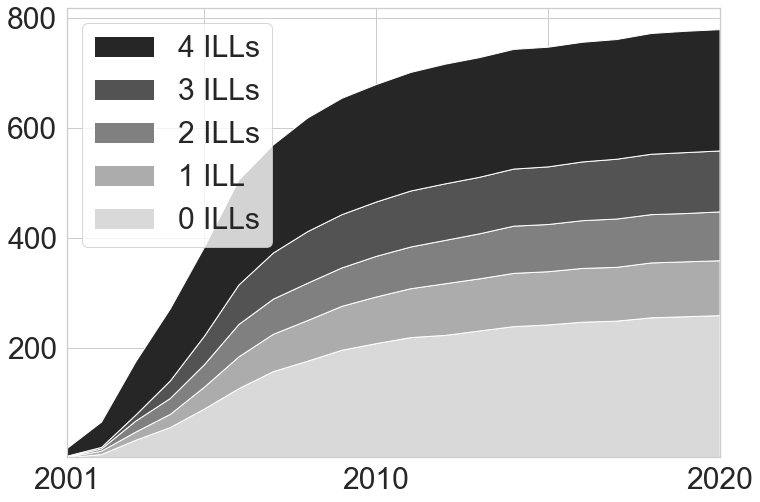

In [154]:
x= yearly_illcounts_rules['year'].values.tolist()
y=[ yearly_illcounts_rules['1'].values.tolist(), yearly_illcounts_rules['2'].values.tolist(), yearly_illcounts_rules['3'].values.tolist(), yearly_illcounts_rules['4'].values.tolist(), yearly_illcounts_rules['5'].values.tolist() ]
 
# Plot
fig, ax = plt.subplots()

ax.stackplot(x,y, labels=['0 ILLs','1 ILL','2 ILLs','3 ILLs','4 ILLs'],colors=sb.color_palette('ch:s=.5,hue=0',n_colors=5))
plt.xticks(ticks=[2001,2005,2010,2015,2020],labels=[2001,'',2010,'',2020],fontsize=30)
plt.yticks(ticks=[0,200,400,600,800],labels=['',200,400,600,800],fontsize=30)
plt.xlim(2001,2020)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left',fontsize=30)
plt.show()
#fig.savefig("./figs/202105_area_rules_withNumILLs.png")

```
def get_num_ills(row):
    #for each page
    num_ills_that_year = 0
    p = row['parent_page_title']
    y = row['year']
    #for each ILL
    for lang in langs:
        # get the interlanguage link
        illdpage = all_creation_year_df.loc[all_creation_year_df.page==p][lang].values[0]

        #if there is an ILL and it's in our existing rule set
        if illdpage != "" and illdpage in all_creation_year_df.page.values.tolist(): 
            # we can check the creation year of that page
            illdpage_cyear = all_creation_year_df.loc[all_creation_year_df.page==illdpage]['creation_year'].values[0]
            # if that year is before/same as our current year y we can include +1 to the num of ills this page had this year
            if int(illdpage_cyear) <= int(y):
                num_ills_that_year += 1
            # else we cannot, so continue
            else:
                continue
        # there is an ILL but it's not in our existing rule set
        elif illdpage != "":
            # we can get the revision history and grab the date
            illdpage_firstyear = pd.concat(wf.get_all_page_revisions(illdpage, endpoint='{}.wikipedia.org/w/api.php'.format(lang))).agg({'date':np.min})['date'].year
            if int(illdpage_firstyear) <= int(y):
                num_ills_that_year += 1
        # there is no link
        else:
            continue 
    return num_ills_that_year
```

    for i,(rev_df,name) in enumerate(zip(allrev_df_list,rev_df_names)):
        print(name)
        # map the page to the num of ills that year
        _df = rev_df.groupby(['creation_year','parent_page_title','year']).agg({'revid':"count"})['revid'].reset_index()
        _df['num_ills_that_year'] = _df.apply(get_num_ills,axis=1)
        _df.to_csv('202104_num_ills_perpage_peryear_{}.tsv'.format(name),sep='\t',index=False,header=True)

    #all_creation_year_df.to_csv('202104_rules_withillcolumns',sep='\t',index=False,header=True)

In [155]:
num_ills_that_year_df_list = [pd.read_csv('202104_num_ills_perpage_peryear_English.tsv',sep='\t'),
                              pd.read_csv('202104_num_ills_perpage_peryear_French.tsv',sep='\t'),
                              pd.read_csv('202104_num_ills_perpage_peryear_German.tsv',sep='\t'),
                              pd.read_csv('202104_num_ills_perpage_peryear_Japanese.tsv',sep='\t'),
                              pd.read_csv('202104_num_ills_perpage_peryear_Spanish.tsv',sep='\t')]

In [156]:
# test number of rules
len(set(pd.concat(num_ills_that_year_df_list).parent_page_title.values.tolist())) # should be 779 since Wikipedia:Spam is both in spanish and english

779

In [157]:
rev_df_names

['English', 'French', 'German', 'Japanese', 'Spanish']

In [160]:
def get_num_rules_with_num_ills_yearly_perlangedition(row):
    year =  row['year']
    num_links_sofar = cy_df.loc[cy_df.creation_year <= year].groupby(by=['num_links']).agg({"page":"sum"}).reset_index()
    _out = [year]
    for i in range(1,6):
        if i in num_links_sofar['num_links'].values.tolist():
            so_far = num_links_sofar.loc[num_links_sofar.num_links==i]['page'].values[0]
            _out.append(so_far)
        else:
            _out.append(0)
    return _out

In [161]:
creation_year_dfs[0]

,page,creation_year,lang,num_links,en,fr,de,ja,es,rc
1,Template:Taxobox/doc,2006,en,1,Template:Taxobox/doc,,,,,210
384,Wikipedia:Accuracy dispute,2003,en,3,Wikipedia:Accuracy dispute,,,Wikipedia:正確性に疑問がある記事,Wikipedia:Veracidad discutida,215
1183,Wikipedia:Administrators,2001,en,5,Wikipedia:Administrators,Wikipédia:Administrateur,Wikipedia:Administratoren,Wikipedia:管理者,Wikipedia:Bibliotecarios,24
4368,Wikipedia:WikiProject Anarchism,2007,en,3,Wikipedia:WikiProject Anarchism,Projet:Anarchisme,,,Wikiproyecto:Acracia,457
5088,Wikipedia:Appealing a block,2006,en,3,Wikipedia:Appealing a block,,Wikipedia:Sperrprüfung,Wikipedia:投稿ブロックへの異議申し立て,,173
...,...,...,...,...,...,...,...,...,...,...
305081,Wikipedia:WikiProject Mining/Style guide,2009,en,1,Wikipedia:WikiProject Mining/Style guide,,,,,466
305094,Wikipedia:WikiProject Swiss municipalities/Art...,2009,en,1,Wikipedia:WikiProject Swiss municipalities/Art...,,,,,467
305110,Wikipedia:Wikimedia sister projects,2004,en,3,Wikipedia:Wikimedia sister projects,Wikipédia:Projets frères,Wikipedia:Schwesterprojekte,,,167
305658,Wikipedia:Wikipedia is not a dictionary,2001,en,5,Wikipedia:Wikipedia is not a dictionary,Wikipédia:Wikipédia n'est pas un dictionnaire,Wikipedia:Wikipedia ist kein Wörterbuch,Wikipedia:ウィキペディアは辞書ではありません,Wikipedia:Wikipedia no es un diccionario,203


English
French
German
Japanese
Spanish


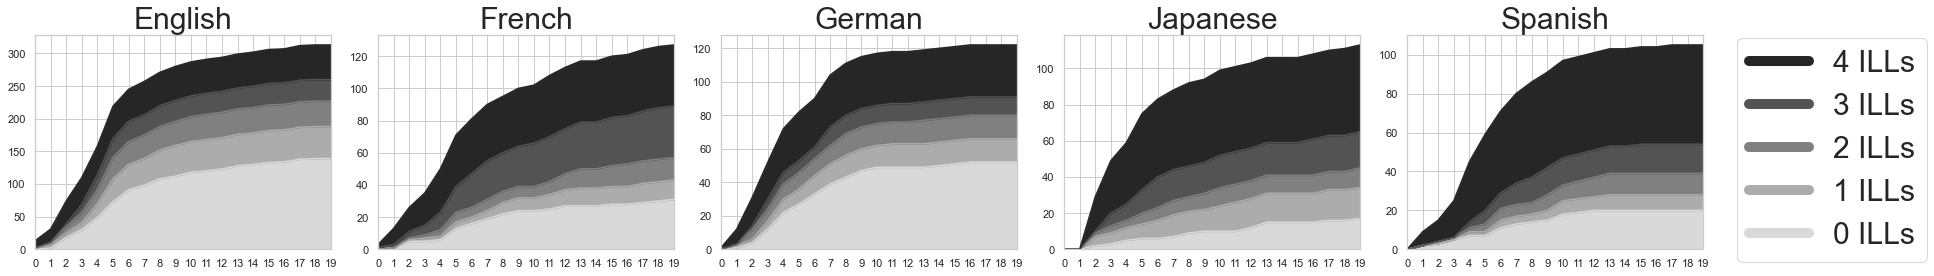

In [162]:
f,axs = plt.subplots(1,5,figsize=(24,4))

for i,(cy_df,name) in enumerate(zip(creation_year_dfs,rev_df_names)):
    print(name)
    # map the page to the num of ills that year
    cy_df = cy_df.groupby(by=['creation_year','num_links']).agg({"page":"count"}).reset_index()
    _df = pd.DataFrame()
    _df['year'] = range(2001,2021)
    _df = pd.DataFrame(_df.apply(get_num_rules_with_num_ills_yearly_perlangedition,axis=1).tolist(),columns=['year','1','2','3','4','5'])
    _df.plot(x='year',kind='area',stacked=True,legend=False,ax=axs[i],color=sb.color_palette('ch:s=.5,hue=0',n_colors=5))

    if name == "Japanesey":
        axs[i].set_xticks(range(2003,2021))
        axs[i].set_xlim(2003,2020)
    else:
        axs[i].set_xticks(range(2001,2021))
        axs[i].set_xlim(2001,2020)
    axs[i].set_xticklabels(range(0,20))
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')

    if i == 0:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        # uncomment if doing percentages
        #axs[i].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        #axs[i].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=30)
    else:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')

        # uncomment if doing percentages
        #axs[i].set_yticklabels(["","","","","",""])


legend_elements = [Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[4], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[3], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[2], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[1], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[0], lw=10)]

reversed_labels = ["4 ILLs","3 ILLs","2 ILLs","1 ILLs","0 ILLs"]

f.legend(legend_elements,reversed_labels,bbox_to_anchor=(1,.9),loc='upper left',fontsize=30)
f.tight_layout()
#f.savefig("./figs/202105_rules_with_x_ills.png")

In [164]:
rev_df_en.year.astype(np.int64).min(),rev_df_fr.year.astype(np.int64).min(),rev_df_de.year.astype(np.int64).min(),rev_df_ja.year.astype(np.int64).min(),rev_df_es.year.astype(np.int64).min()

(2001, 2001, 2001, 2003, 2002)

English
French
German
<ipython-input-173-c9f4f424c9cd>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-173-c9f4f424c9cd>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-173-c9f4f424c9cd>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
Japanese
Spanish
<ipython-input-173-c9f4f424c9cd>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])


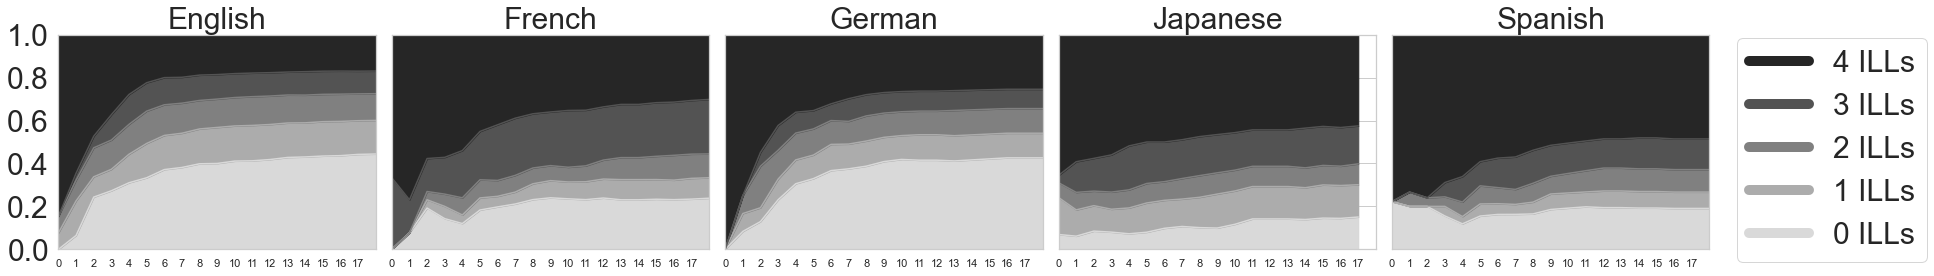

In [173]:
f,axs = plt.subplots(1,5,figsize=(24,4))

for i,(cy_df,name) in enumerate(zip(creation_year_dfs,rev_df_names)):
    print(name)
    # map the page to the num of ills that year
    cy_df = cy_df.groupby(by=['creation_year','num_links']).agg({"page":"count"}).reset_index()
    _df = pd.DataFrame()
    _df['year'] = range(2001,2021)
    _df = pd.DataFrame(_df.apply(get_num_rules_with_num_ills_yearly_perlangedition,axis=1).tolist(),columns=['year','1','2','3','4','5'])

    ### For percentages instead
    _df['total_rules_num'] = _df['1'] + _df['2'] + _df['3'] + _df['4'] + _df['5']

    for number in ['1','2','3','4','5']:
        _df[number] = _df[number].astype(np.float32) / _df.total_rules_num.astype(np.float32)
    _df.drop(columns=['total_rules_num'],inplace=True)
    ### -------------------/
    _df.plot(x='year',kind='area',stacked=True,legend=False,ax=axs[i],color=sb.color_palette('ch:s=.5,hue=0',n_colors=5))

    if name == "Japanese":
        axs[i].set_xticks(range(2003,2021))
        axs[i].set_xlim(2003,2021)
    elif name == "Spanish":
        axs[i].set_xticks(range(2002,2020))
        axs[i].set_xlim(2002,2020)
    else:
        axs[i].set_xticks(range(2001,2019))
        axs[i].set_xlim(2001,2019)
    axs[i].set_xticklabels(range(0,18))
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')
    axs[i].set_ylim(0,1)

    if i == 0:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        # uncomment if doing percentages
        axs[i].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        axs[i].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=30)
    else:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')

        # uncomment if doing percentages
        axs[i].set_yticklabels(["","","","","",""])

legend_elements = [Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[4], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[3], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[2], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[1], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[0], lw=10)]

reversed_labels = ["4 ILLs","3 ILLs","2 ILLs","1 ILLs","0 ILLs"]

f.legend(legend_elements,reversed_labels,bbox_to_anchor=(1,.9),loc='upper left',fontsize=30)
f.tight_layout()

f.savefig("./figs/202106_percent_rules_with_x_ills.png")

In [175]:
def get_total_revs_that_year(row):
    y = row.year
    #print(total_revs_in_year)
    return total_revs_in_year['revid'][y]

English
French
German
Japanese
Spanish
<ipython-input-176-65146faa4c62>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-176-65146faa4c62>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-176-65146faa4c62>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])
<ipython-input-176-65146faa4c62>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["","","","","",""])


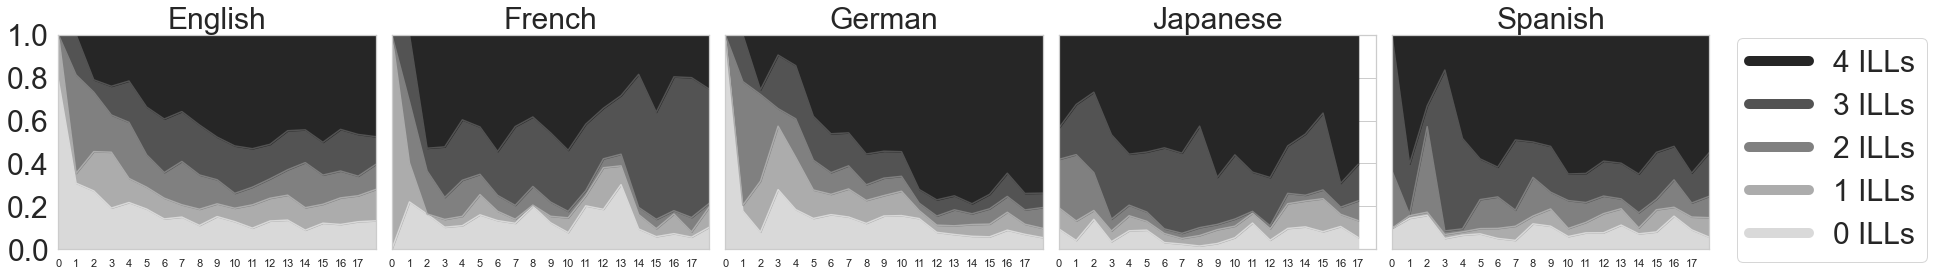

In [176]:
#Percent of rule-related revisions going to rules with 0,1,2,3,4 ILLs across lang editions.
f,axs = plt.subplots(1,5,figsize=(24,4))

for i,(yearlyillcount_rev_df,name) in enumerate(zip(num_ills_that_year_df_list,rev_df_names)):
    print(name)
    # map the page to the num of ills that year
    _df = yearlyillcount_rev_df.groupby(['year','num_ills_that_year']).agg({'revid':'sum'}).reset_index()
    _df['lang'] = name

    total_revs_in_year = _df.groupby(['year']).agg({'revid':sum}).to_dict()
    _df['total_revs_yearly'] = _df.apply(get_total_revs_that_year,axis=1)

    _df["percentage_revs"] = _df.revid.astype(np.float32) / _df.total_revs_yearly.astype(np.float32)
    _df = _df.groupby(["lang","year","num_ills_that_year"]).agg({"percentage_revs":"sum"}).reset_index()
    _df = _df.pivot(index="year",columns="num_ills_that_year",values="percentage_revs").fillna(value=0)\

    if 0 in list(_df.columns):
        _df["temp_col"] = _df[0] + _df[1]
        _df[1] = _df["temp_col"]
        _df = _df.drop(columns=[0,"temp_col"])

    _df.plot(kind='area',stacked=True,legend=False,ax=axs[i],color=sb.color_palette('ch:s=.5,hue=0',n_colors=5))

    if name == "Japanese":
        axs[i].set_xticks(range(2003,2021))
        axs[i].set_xlim(2003,2021)
    elif name == "Spanish":
        axs[i].set_xticks(range(2002,2020))
        axs[i].set_xlim(2002,2020)
    else:
        axs[i].set_xticks(range(2001,2019))
        axs[i].set_xlim(2001,2019)
    axs[i].set_xticklabels(range(0,18))
    axs[i].set_title(name,fontsize=13)
    axs[i].set_xlabel('')
    axs[i].set_ylim(0,1)

    if i == 0:
        #axs[i].set_xticklabels(range(0,20))
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        axs[i].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        axs[i].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=30)

    else:
        axs[i].set_title(name,fontsize=30)
        axs[i].set_xlabel('')
        axs[i].set_yticklabels(["","","","","",""])

legend_elements = [Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[4], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[3], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[2], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[1], lw=10),
                   Line2D([0], [0], color=sb.color_palette('ch:s=.5,hue=0',n_colors=5)[0], lw=10)]

reversed_labels = ["4 ILLs","3 ILLs","2 ILLs","1 ILLs","0 ILLs"]

f.legend(legend_elements,reversed_labels,bbox_to_anchor=(1,.9),loc='upper left',fontsize=30)
f.tight_layout();

f.savefig("./figs/202106_percent_revs_toruleswithXills.png")